In [27]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from numpy import linalg as LA

#import sys
#sys.path.append("..")

from utils import *
from dictionary import *
from vis import *
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import skimage.color as skcolor
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cv2
# import ipdb

In [28]:
# SR_MFSR.py
from skimage import io as skio 
from skimage import color as skco
from skimage import transform


class MFSR():
    def __init__(self, img, psize=6, upscale=3, conscale=3, beta=0.1, dtype=1, 
                 overlap=5, alpha1=0.0001, alpha2=0.001, ref_num=10, rdtype=11):
        self.W = img.shape[0]
        self.H = img.shape[1]
        self.uW = self.W * upscale
        self.uH = self.H * upscale
        self.cW = self.W * conscale
        self.cH = self.H * conscale
        self.w = psize
        self.h = psize
        self.uw = psize * upscale
        self.uh = psize * upscale
        
        self.img_L_rgb = img
        
        self.psize = psize
        self.upscale = upscale
        self.conscale = conscale
        self.beta = beta
        self.overlap = overlap
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.ref_num = ref_num
        
        self.dtype = dtype
        self.rdtype = rdtype

    
    def update_dic(self, dtype):
        self.dic = Dictionary(upscale=self.upscale, dtype=dtype, psize=6)
        # self.dic_r = Dictionary(upscale=upscale, dtype=60, psize=psize)
        
        self.DL = self.dic.L['data'].transpose()
        self.DH = self.dic.H['data'].transpose()
        self.norm_L = np.sqrt(np.sum(self.DL**2, axis = 0))
        self.DL /= self.norm_L  
        self.DH /= self.norm_L
        
    def super_resolution2(self):
        self.img_L = self.img_L_rgb / 255.0
        self.img_H_y = np.zeros((self.uW, self.uH))
        
        self.update_dic(self.dtype)
        self.sample_patches()
        self.sparse_rep()
        self.reconstruct1()
        
        # self.update_dic(self.rdtype)
        # self.sample_patches()
        self.refine()
        self.reconstruct2()
        
        
        self.unify()
        self.img_H_rgb = self.img_H_y * 255.0
        
        
        
    def super_resolution(self):        
        img_L_ycbcr = skco.rgb2ycbcr(self.img_L_rgb)
        img_L_y = img_L_ycbcr[:, :, 0]
        img_L_cb = img_L_ycbcr[:, :, 1]
        img_L_cr = img_L_ycbcr[:, :, 2]
        self.img_L = img_L_y / 255.0
        
        
        self.img_H_y = np.zeros((self.uW, self.uH))
        
        self.update_dic(self.dtype)
        self.sample_patches()
        self.sparse_rep()
        self.reconstruct1()
        
        # self.update_dic(self.rdtype)
        # self.sample_patches()
        self.refine()
        self.reconstruct2()
        # self.back_projection()
        # self.procedure.append([self.img_H.copy(), 'After MFSR'])
            
        img_H_cb = transform.resize(img_L_cb,(self.cW, self.cH),order=1)
        img_H_cr = transform.resize(img_L_cr,(self.cW, self.cH),order=1)
        
        img_H_ycbcr = np.zeros((self.cW, self.cH, 3))
        img_H_ycbcr[:, :, 0] = self.img_H_y * 255.0
        img_H_ycbcr[:, :, 1] = img_H_cb
        img_H_ycbcr[:, :, 2] = img_H_cr
        
        self.img_H_rgb = skco.ycbcr2rgb(img_H_ycbcr)
        
        # self.unify()
        
        
    def unify(self):
        self.img_H_y[self.img_H_y < 0] = 0
        self.img_H_y[self.img_H_y > 1] = 1
        
    
    
    
    def sparse_rep(self):
        self.img_H = np.zeros((self.uW, self.uH))
        self.img_cnt = np.zeros((self.uW, self.uH))
        
        uw = self.w * self.upscale
        uh = self.h * self.upscale
        u = self.upscale
        
        #===========================================================
        #  set the lasso optimizer
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=self.alpha1, max_iter=50, fit_intercept=False)
           
        count = 0
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            roi_L = patch['data'].copy()
            # roi_L = self.img_L[lt_x:lt_x + self.w, lt_y:lt_y + self.h]                                            
            y = roi_L.reshape(-1, 1)
            
            #===== norm =====
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y >0 : y /= norm_y
            
            #===========================================================
            #  lasso optimizer
            clf.fit(self.DL, y)
            alpha = np.array(clf.coef_).reshape(-1, 1)
            
            count += 1
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            if count % 1000 == 0:
                print("patch count: ", count, "    loss: ", loss)        
            patch['rep'] = alpha

    
    def refine(self):
        #===========================================================
        #  set the lasso optimizer
        from sklearn import linear_model
        clf = linear_model.Lasso(alpha=self.alpha2, max_iter=10, fit_intercept=False)
        
        scales = [7/6, 8/6, 9/6, 10/6, 11/6, 12/6]
        sref_num = [1, 1, 1, 1, 0, 2]
        N_scale = len(scales)
        
        for i in range(N_scale):
            scale, ref_num = scales[i], sref_num[i]
            DH = upscale_dic(self.dic.L, upscale = scale)['data'].transpose()
            sw, sh = int(scale * 6), int(scale * 6)
            DH /= self.norm_L
            print("Scale " , sh , " started ")
            
            for patch in self.patches:
                
                roi_L = patch['data'].copy()
                
                mean_y = np.mean(roi_L)
                roi_L -= mean_y
                norm_y = np.sqrt(np.sum(roi_L**2))
                if norm_y > 0 : roi_L /= norm_y
                
                
                for iter_ in range(ref_num):
                    # ipdb.set_trace()
                    alpha = patch['rep']
                    rep_H = np.dot(DH, alpha).reshape(sw, sh)
                    rep_L = transform.resize(rep_H, (6, 6), order=1)

                    res_y = roi_L.reshape(-1, 1) - rep_L.reshape(-1, 1)

                    clf.fit(self.DL, res_y)
                    alpha_res = np.array(clf.coef_).reshape(-1, 1)

                    patch['rep'] += alpha_res
                        
            
            
    def reconstruct1(self):
        img_H = np.zeros((self.cW, self.cH))
        img_cnt = np.zeros((self.cW, self.cH))
        
        uw = self.w * self.conscale
        uh = self.h * self.conscale
        u = self.conscale
        DH = upscale_dic(self.dic.L, upscale = u)['data'].transpose()
        DH /= self.norm_L
        
        
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            y = patch['data'].reshape(-1, 1)
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y > 0 : y /= norm_y
            
            alpha = patch['rep']
            roi_H_SR = np.dot(DH, alpha).reshape(uw, uh)
            if norm_y > 0 : roi_H_SR *= norm_y
            roi_H_SR += mean_y
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            # loss = 1
            weight = (1.0 / (loss + 1e-4))
            
        
            img_H[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += roi_H_SR * weight
            
            # Region of sum weight
            img_cnt[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += (weight)
            
            
        # Fall back strategy like bicubic interpolation is used   
        if (img_cnt == 0).any():
            print('Fall back strategy')
            mask = (img_cnt == 0)
            mask_bicubic = mask * transform.resize(self.img_L, (self.cW, self.cH), order=1)
            img_cnt += mask # To ensure all  sum weight in sum weight matrix img_cnt not equal 0
            img_H += mask_bicubic # Fall back strategy to ensure all pixel of img_H are covered (handle)
        img_H = img_H / img_cnt
        self.img_L -= transform.resize(img_H, (self.W, self.H), order=1)
        
        self.img_H_y += img_H
        
        # ipdb.set_trace()
        
    def reconstruct2(self):
        img_H = np.zeros((self.cW, self.cH))
        img_cnt = np.zeros((self.cW, self.cH))
        
        uw = self.w * self.conscale
        uh = self.h * self.conscale
        u = self.conscale
        DH = upscale_dic(self.dic.L, upscale = u)['data'].transpose()
        # ipdb.set_trace()
        # filter_dic(self.dic.L, DH)
        DH /= self.norm_L
        
        
        
        for patch in self.patches:
            lt_x, lt_y = patch['pos']
            y = patch['data'].reshape(-1, 1)
            mean_y = np.mean(y)
            y -= mean_y
            norm_y = np.sqrt(np.sum(y**2))
            if norm_y > 0 : y /= norm_y
            
            alpha = patch['rep']
            roi_H_SR = np.dot(DH, alpha).reshape(uw, uh)
            if norm_y > 0 : roi_H_SR *= norm_y
            roi_H_SR += mean_y
            loss = LA.norm(y - np.dot(self.DL, alpha), 2) + self.alpha1 * LA.norm(alpha, 1)
            # loss = 1
            weight = (1.0 / (loss + 1e-4))
            
        
            img_H[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += roi_H_SR * weight
            img_cnt[lt_x * u: lt_x * u + uw, lt_y * u: lt_y * u + uh] += (weight)
            
            
        if (img_cnt == 0).any():
            print('Fall back strategy')
            mask = (img_cnt == 0)
            mask_bicubic = mask * transform.resize(self.img_L, (self.cW, self.cH), order=1)
            img_cnt += mask
            img_H += mask_bicubic
        img_H = img_H / img_cnt
        # self.img_L -= transform.resize(img_H, (self.W, self.H), order=1)
        
        self.img_H_y += img_H

    
        
    def sample_patches(self):
        self.patches = []
        for i in range(0, self.W, self.psize - self.overlap):
            for j in range(0, self.H, self.psize - self.overlap):
                if i + self.w >= self.W or j + self.h >= self.H: continue   
                tmp = {}
                tmp['data'] = self.img_L[i:i+self.w, j:j+self.h]
                tmp['pos'] = (i, j)
                tmp['rep'] = np.zeros((self.dic.size, 1))
                self.patches.append(tmp)

In [8]:
img_id_list = [(f'0'*(3-len(str(i))) + str(i)) for i in range(1, 101)]

results = []
results_img = []

dataset_route = './BSD100'
for img_id in img_id_list:
    print(f'Super resolution using HFSR for img_{img_id}')
    conscale = 2
    img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
    if len(img_L_rgb.shape) == 2:
        img_L_rgb = skcolor.gray2rgb(img_L_rgb)


    # vis_img(img_L_rgb)
    MFSR_1 = MFSR(img_L_rgb, rdtype=11, dtype=6, overlap=4, psize=6, alpha2=0.0001, 
                conscale=conscale, upscale=2)
    MFSR_1.super_resolution()
    psnr_, ssim_ = quick_eval(dataset_route, MFSR_1.img_H_rgb, img_id=img_id, scale=conscale)
    results.append((img_id, psnr_, ssim_))
    results_img.append(np.array(MFSR_1.img_H_rgb))
    
    file_path = dataset_route.replace('./', '')
    np.save(arr=results, file=f'results_{file_path}.npy')
    print(f'Save mark of {img_id} successfully to results.npy')

# np.save(arr=results_img, file='results_img.npy')
# print('Save img_H_rgb sucessfully to results_img.npy')

Super resolution using HFSR for img_001
img_route: ./BSD100
./BSD100\image_SRF_2/img_001_SRF_2_LR.png
6
size of the dic is : 334
patch count:  1000     loss:  0.01837090598605355
patch count:  2000     loss:  0.018988389734516983
patch count:  3000     loss:  0.018520845451841496
patch count:  4000     loss:  0.017497220581818382
patch count:  5000     loss:  0.019882430940689574
patch count:  6000     loss:  0.018526678288032217
patch count:  7000     loss:  0.01915448684393227
patch count:  8000     loss:  0.019031108923752933
patch count:  9000     loss:  0.01899394117625291
11
size of the dic is : 162
Scale  7  started 
Scale  8  started 
Scale  9  started 
Scale  10  started 
Scale  11  started 
Scale  12  started 
img_route: ./BSD100
./BSD100\image_SRF_2/img_001_SRF_2_HR.png
quick_eval: ./BSD100
PSNR/SSIM for None: 26.0871 dB / 0.7796
Save mark of 001 successfully to results.npy
Super resolution using HFSR for img_002
img_route: ./BSD100
./BSD100\image_SRF_2/img_002_SRF_2_LR.png


Lấy chỉ số psnr trung bình, ssim trung bình của tập dữ liệu

In [27]:
dataset_names = ['Set5', 'Set14', 'BSD100', 'Urban100']
for dataset_name in dataset_names:
    data = np.load(f'Results/results_for_bilinear_{dataset_name}.npy')
    psnr_all = [float(x[1]) for x in data]
    ssim_all = [float(x[2]) for x in data]
    print(f'Data {dataset_name}:\t{round(psnr_all[2], 2), round(ssim_all[2], 2)}')

Data Set5:	(26.0, 0.87)
Data Set14:	(27.04, 0.77)
Data BSD100:	(27.53, 0.85)
Data Urban100:	(25.48, 0.77)


In [30]:
conscale = 2
img_id = '001'
dataset_route = './Set14'
img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
if len(img_L_rgb.shape) == 2:
    img_L_rgb = skcolor.gray2rgb(img_L_rgb)


# vis_img(img_L_rgb)
MFSR_1 = MFSR(img_L_rgb, rdtype=6, dtype=6, overlap=4, psize=6, alpha2=0.0001, 
            conscale=conscale, upscale=2)
MFSR_1.super_resolution()
psnr_, ssim_ = quick_eval(dataset_route=dataset_route, img_O=MFSR_1.img_H_rgb, img_id=img_id, scale=conscale, file_name=img_id)

img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_LR.png
6
size of the dic is : 334
patch count:  1000     loss:  0.018936892170437678
patch count:  2000     loss:  0.018728203773530322
patch count:  3000     loss:  0.018487073236723852
patch count:  4000     loss:  0.018338419751383974
patch count:  5000     loss:  0.018797281954657484
patch count:  6000     loss:  0.019303559913053953
patch count:  7000     loss:  0.018111595952445755
patch count:  8000     loss:  0.01915365591650194
patch count:  9000     loss:  0.01910342339298256
patch count:  10000     loss:  0.018047631193517297
patch count:  11000     loss:  0.01947769730518641
patch count:  12000     loss:  0.018218951019210478
patch count:  13000     loss:  0.017346839228383232
patch count:  14000     loss:  0.01919941509685724
Fall back strategy
Scale  7  started 
Scale  8  started 
Scale  9  started 
Scale  10  started 
Scale  11  started 
Scale  12  started 
Fall back strategy
img_route: ./Set14
./Set14\image_SRF_2/img_

Thực nghiệm với các bộ dữ liệu sử dụng bilinear

In [30]:
img_id_list = [(f'0'*(3-len(str(i))) + str(i)) for i in range(1, 101)]

results = []
results_img = []

dataset_route = './Urban100'
for img_id in img_id_list:
    print(f'Super resolution using HFSR for img_{img_id}')
    conscale = 2
    img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
    if len(img_L_rgb.shape) == 2:
        img_L_rgb = skcolor.gray2rgb(img_L_rgb)

    new_size_up = (int(img_L_rgb.shape[1] * 2), int(img_L_rgb.shape[0] * 2))
    img_bilinear_up = cv2.resize(img_L_rgb, new_size_up, interpolation=cv2.INTER_LINEAR)
    psnr_, ssim_ = quick_eval(dataset_route, img_bilinear_up, img_id=img_id, scale=conscale)
    results.append((img_id, psnr_, ssim_))
    results_img.append(np.array(MFSR_1.img_H_rgb))
    
    file_path = dataset_route.replace('./', '')
    np.save(arr=results, file=f'Results/results_for_bilinear_{file_path}.npy')
    print(f'Save mark of {img_id} successfully to results.npy')

# np.save(arr=results_img, file='results_img.npy')
# print('Save img_H_rgb sucessfully to results_img.npy')

Super resolution using HFSR for img_001
img_route: ./Urban100
./Urban100\image_SRF_2/img_001_SRF_2_LR.png
img_route: ./Urban100
./Urban100\image_SRF_2/img_001_SRF_2_HR.png
quick_eval: ./Urban100
PSNR/SSIM for None: 28.0190 dB / 0.8473
Save mark of 001 successfully to results.npy
Super resolution using HFSR for img_002
img_route: ./Urban100
./Urban100\image_SRF_2/img_002_SRF_2_LR.png
img_route: ./Urban100
./Urban100\image_SRF_2/img_002_SRF_2_HR.png
quick_eval: ./Urban100
PSNR/SSIM for None: 26.7097 dB / 0.8339
Save mark of 002 successfully to results.npy
Super resolution using HFSR for img_003
img_route: ./Urban100
./Urban100\image_SRF_2/img_003_SRF_2_LR.png
img_route: ./Urban100
./Urban100\image_SRF_2/img_003_SRF_2_HR.png
quick_eval: ./Urban100
PSNR/SSIM for None: 25.4807 dB / 0.7664
Save mark of 003 successfully to results.npy
Super resolution using HFSR for img_004
img_route: ./Urban100
./Urban100\image_SRF_2/img_004_SRF_2_LR.png
img_route: ./Urban100
./Urban100\image_SRF_2/img_004_S

: 

In [31]:
path = img_route(dataset_route=dataset_route, img_id=img_id, method='LR', scale=conscale)
        
# Đọc ảnh LR
img_L = cv2.imread(path, cv2.IMREAD_COLOR)
img_L = cv2.cvtColor(img_L, cv2.COLOR_BGR2RGB)

# Tham số phóng đại
scale_up = 2.0
new_size_up = (int(img_L.shape[1] * scale_up), int(img_L.shape[0] * scale_up))

# Nearest Neighbor
img_nearest_up = cv2.resize(img_L, new_size_up, interpolation=cv2.INTER_NEAREST)
        
# Bicubic
img_bicubic_up = cv2.resize(img_L, new_size_up, interpolation=cv2.INTER_CUBIC)

img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_LR.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24275662389059413..0.9977220566428447].


img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_HR.png
img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_LR.png


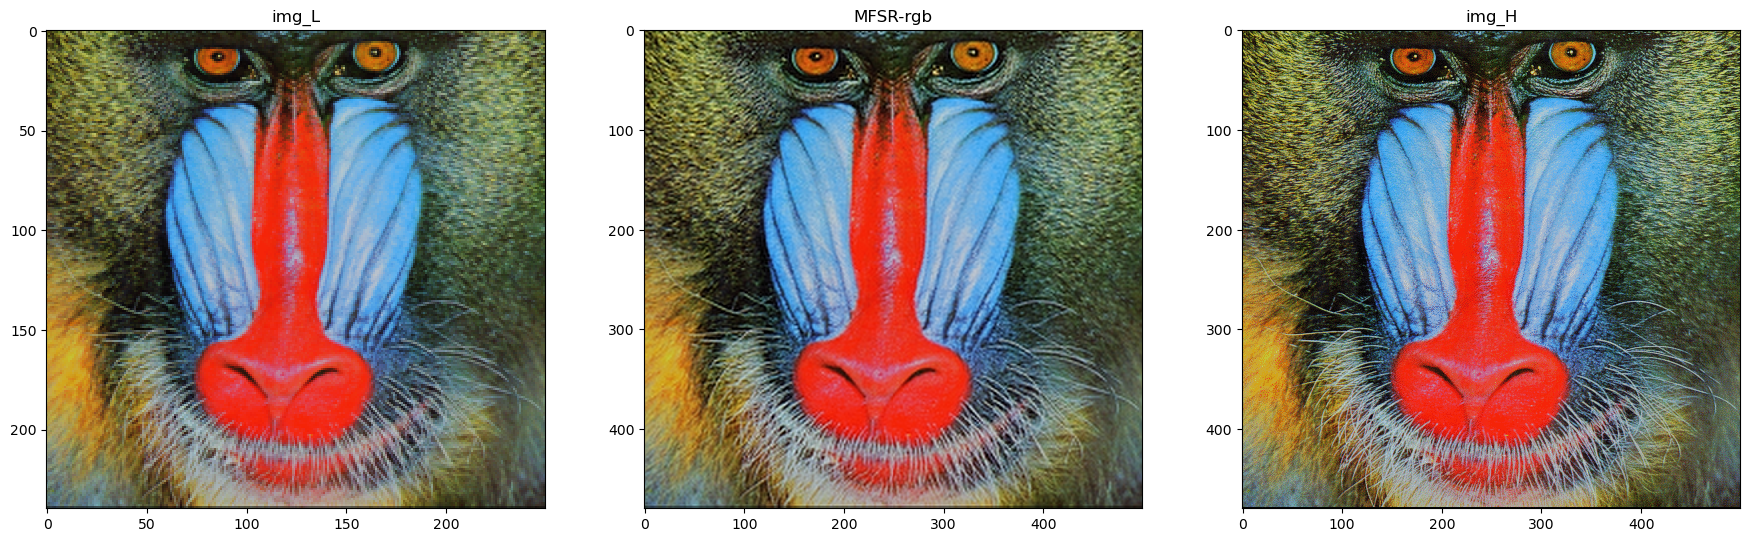

In [32]:
img_H_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, method='HR', scale=conscale))
img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
img_H_hfsr = MFSR_1.img_H_rgb

imgs = []
imgs.append((img_L_rgb, 'img_L'))
imgs.append((MFSR_1.img_H_rgb, 'MFSR-rgb'))
imgs.append((img_H_rgb, 'img_H'))
vis_imgs(imgs, v_max=255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24275662389059413..0.9977220566428447].


img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_HR.png
img_route: ./Set14
./Set14\image_SRF_2/img_001_SRF_2_LR.png


C:\Users\phuoc\AppData\Local\Temp\ipykernel_5284\1454906844.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


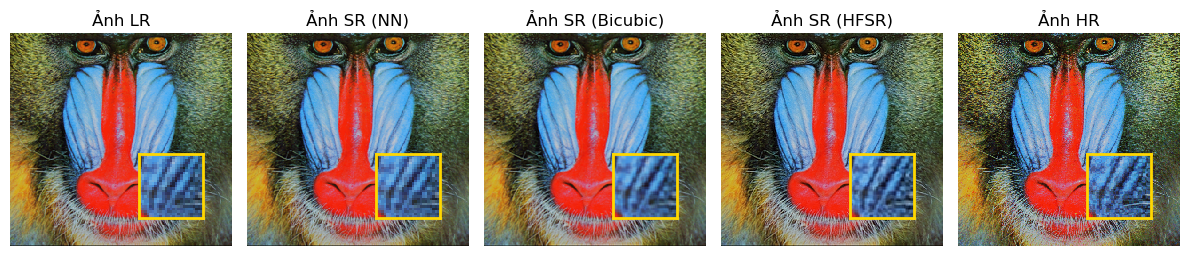

In [33]:
img_H_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, method='HR', scale=conscale))
img_L_rgb = skio.imread(img_route(dataset_route=dataset_route, img_id = img_id, scale=conscale))
img_H_hfsr = MFSR_1.img_H_rgb

scale = 2
x_hr, y_hr, w_hr, h_hr = 310, 280, 50, 50

# Vị trí tương ứng trên LR
x_lr, y_lr, w_lr, h_lr = x_hr // scale, y_hr // scale, w_hr // scale, h_hr // scale

# Chuẩn bị
images = [img_L_rgb, img_nearest_up, img_bicubic_up, img_H_hfsr, img_H_rgb]
patches = [
        img_L_rgb[y_lr:y_lr+h_lr, x_lr:x_lr+w_lr],
        img_nearest_up[y_hr:y_hr+h_hr, x_hr:x_hr+w_hr],
        img_bicubic_up[y_hr:y_hr+h_hr, x_hr:x_hr+w_hr],
        img_H_hfsr[y_hr:y_hr+h_hr, x_hr:x_hr+w_hr],
        img_H_rgb[y_hr:y_hr+h_hr, x_hr:x_hr+w_hr]
        ]
titles = ["Ảnh LR", "Ảnh SR (NN)", "Ảnh SR (Bicubic)", "Ảnh SR (HFSR)", "Ảnh HR"]

# Vẽ
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    axs[i].imshow(images[i])
    axs[i].set_title(titles[i])
    axs[i].axis('off')

    # Vẽ khung vàng
    if i == 0:
        axs[i].add_patch(plt.Rectangle((x_lr, y_lr), w_lr, h_lr, edgecolor='yellow', facecolor='none', lw=2))
    else:
        axs[i].add_patch(plt.Rectangle((x_hr, y_hr), w_hr, h_hr, edgecolor='yellow', facecolor='none', lw=2))

    # Vẽ vùng zoom nhỏ
    axins = inset_axes(axs[i], width="30%", height="30%", loc='lower right', borderpad=2)
    axins.imshow(patches[i])
    axins.set_xticks([])
    axins.set_yticks([])
    for spine in axins.spines.values():
        spine.set_edgecolor('gold')
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()